# EDA — Fraud Data

> **Task 1 · Part A**: Data understanding, class distribution analysis, and country-level fraud patterns.

In [1]:
import sys
sys.path.insert(0, '..')

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.eda.eda import (
    load_fraud_data, load_ip_country,
    handle_missing_values, remove_duplicates, fix_dtypes,
    analyze_class_distribution,
    get_country_fraud_stats, get_top_countries_by_fraud_count, get_top_countries_by_fraud_rate,
)
from src.eda.featuring.preprocess import merge_with_geolocation

sns.set_theme(style='whitegrid', palette='husl')
print("Imports OK")

Imports OK


## 1. Load Data

In [2]:
fraud_df = load_fraud_data('../data/Fraud_Data.csv')
ip_df    = load_ip_country('../data/IpAddress_to_Country.csv')
print(f"Fraud data shape: {fraud_df.shape}")
print(f"IP lookup shape:  {ip_df.shape}")
fraud_df.head()

Fraud data shape: (151112, 11)
IP lookup shape:  (138846, 3)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


## 2. Data Quality

In [3]:
print("=== Missing values ===")
print(fraud_df.isnull().sum())
print()
print("=== Dtypes ===")
print(fraud_df.dtypes)

=== Missing values ===
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

=== Dtypes ===
user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object


In [4]:
fraud_df = fix_dtypes(fraud_df)
fraud_df = handle_missing_values(fraud_df)
fraud_df = remove_duplicates(fraud_df)
print(f"After cleaning: {fraud_df.shape}")

After cleaning: (151112, 11)


## 3. Class Distribution

Class counts:     {0: 136961, 1: 14151}
Fraud percentage: 9.365%
Imbalance ratio:  9.68:1


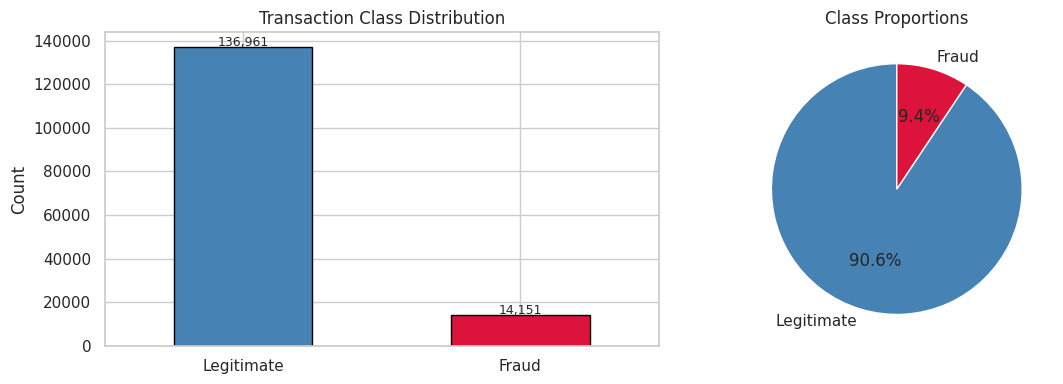

Plot saved.


In [5]:
dist = analyze_class_distribution(fraud_df, target_col='class')
print(f"Class counts:     {dist['counts']}")
print(f"Fraud percentage: {dist['fraud_pct']}%")
print(f"Imbalance ratio:  {dist['imbalance_ratio']}:1")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
counts = pd.Series(dist['counts']).rename({0: 'Legitimate', 1: 'Fraud'})
counts.plot(kind='bar', ax=axes[0], color=['steelblue', 'crimson'], edgecolor='black')
axes[0].set_title('Transaction Class Distribution')
axes[0].set_ylabel('Count'); axes[0].set_xticklabels(['Legitimate', 'Fraud'], rotation=0)
for bar in axes[0].patches:
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+500,
                 f'{int(bar.get_height()):,}', ha='center', fontsize=9)

# Pie chart
axes[1].pie(list(dist['counts'].values()), labels=['Legitimate', 'Fraud'],
            colors=['steelblue', 'crimson'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Proportions')

plt.tight_layout()
plt.savefig('../models/plots/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plot saved.")

## 4. Univariate Analysis

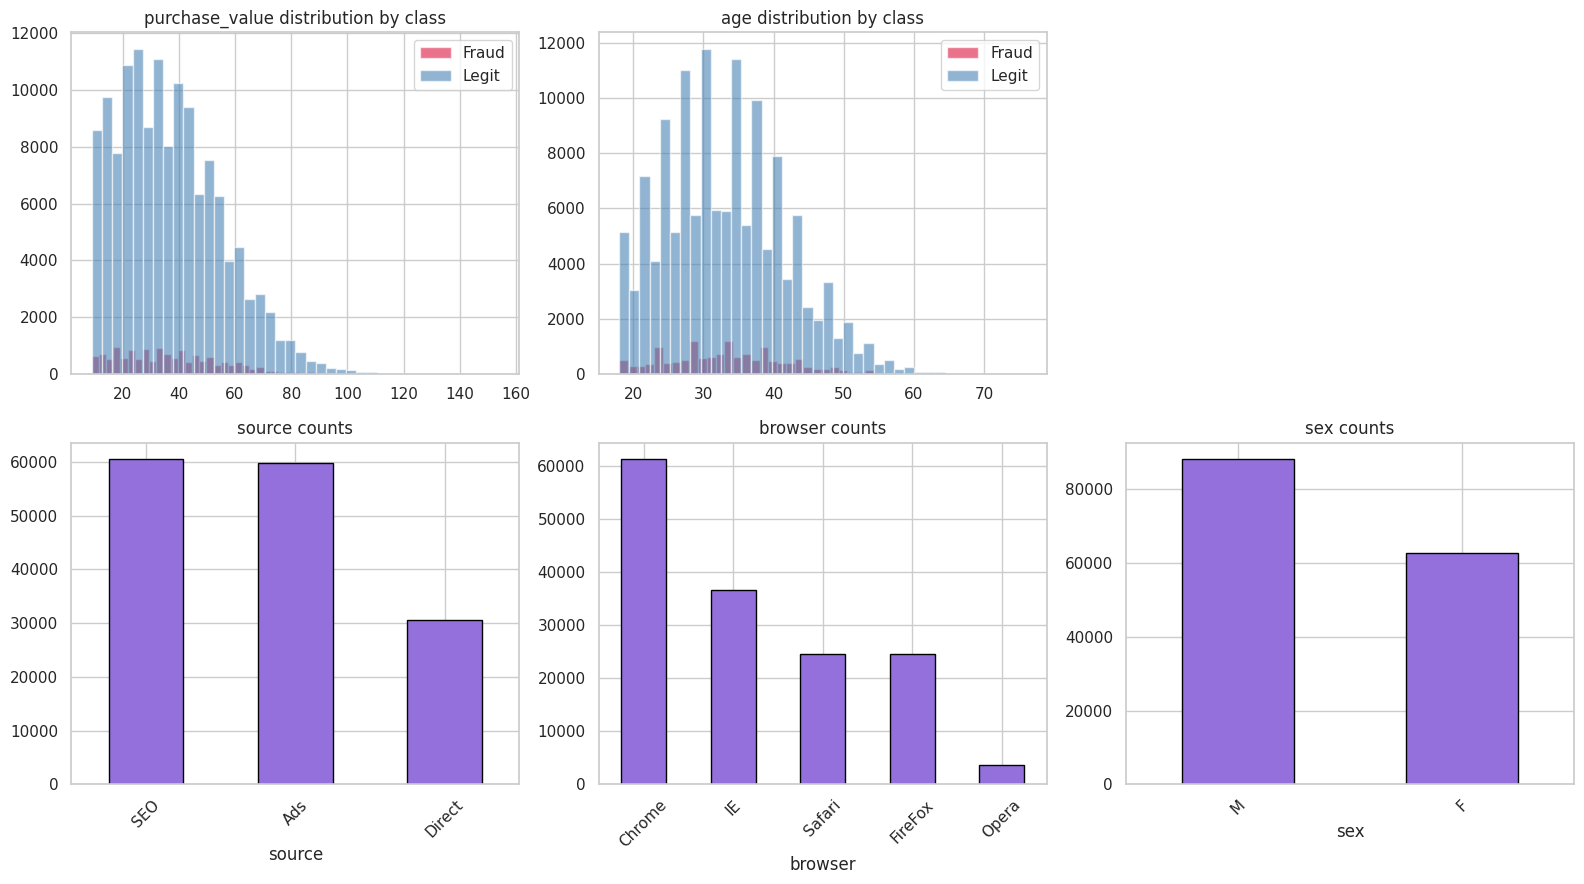

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

numeric_cols = ['purchase_value', 'age']
cat_cols     = ['source', 'browser', 'sex']

for i, col in enumerate(numeric_cols):
    ax = axes[0, i]
    fraud_df[fraud_df['class']==1][col].hist(bins=40, ax=ax, color='crimson', alpha=0.6, label='Fraud')
    fraud_df[fraud_df['class']==0][col].hist(bins=40, ax=ax, color='steelblue', alpha=0.6, label='Legit')
    ax.set_title(f'{col} distribution by class')
    ax.legend()

for i, col in enumerate(cat_cols):
    ax = axes[1, i]
    top = fraud_df[col].value_counts().head(8)
    top.plot(kind='bar', ax=ax, color='mediumpurple', edgecolor='black')
    ax.set_title(f'{col} counts')
    ax.tick_params(axis='x', rotation=45)

axes[0, 2].set_visible(False)
plt.tight_layout()
plt.savefig('../models/plots/univariate.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Bivariate — Fraud Rate by Category

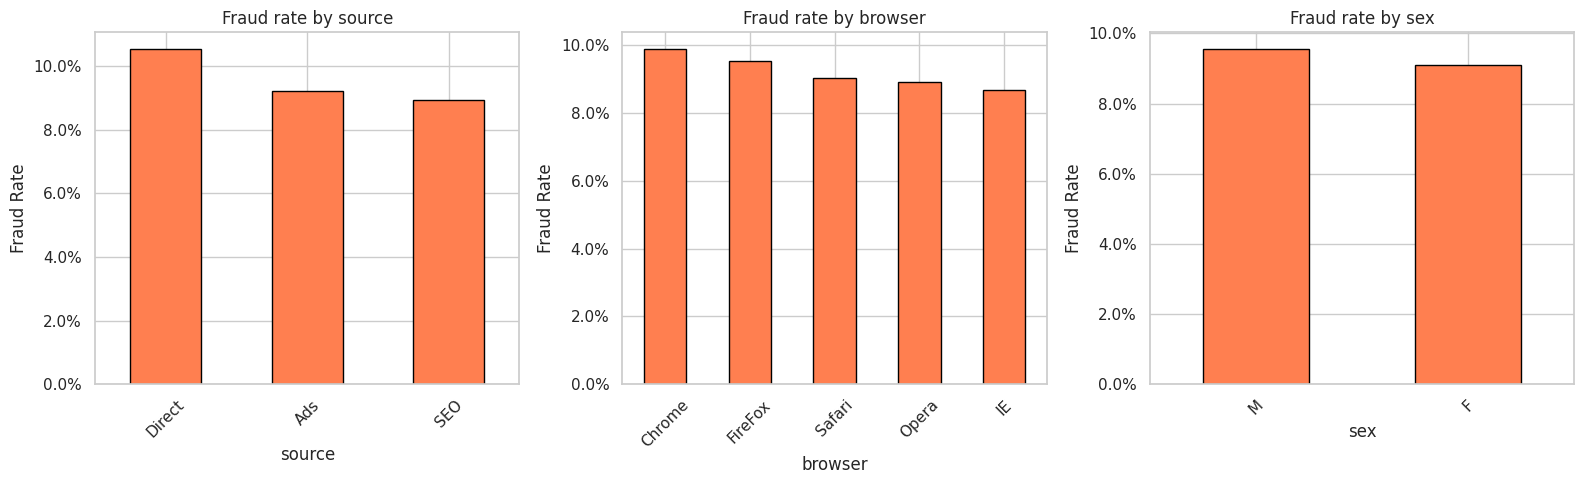

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, col in zip(axes, ['source', 'browser', 'sex']):
    rates = fraud_df.groupby(col)['class'].mean().sort_values(ascending=False)
    rates.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
    ax.set_title(f'Fraud rate by {col}')
    ax.set_ylabel('Fraud Rate')
    ax.tick_params(axis='x', rotation=45)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))

plt.tight_layout()
plt.savefig('../models/plots/bivariate_categorical.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Geolocation — Fraud by Country

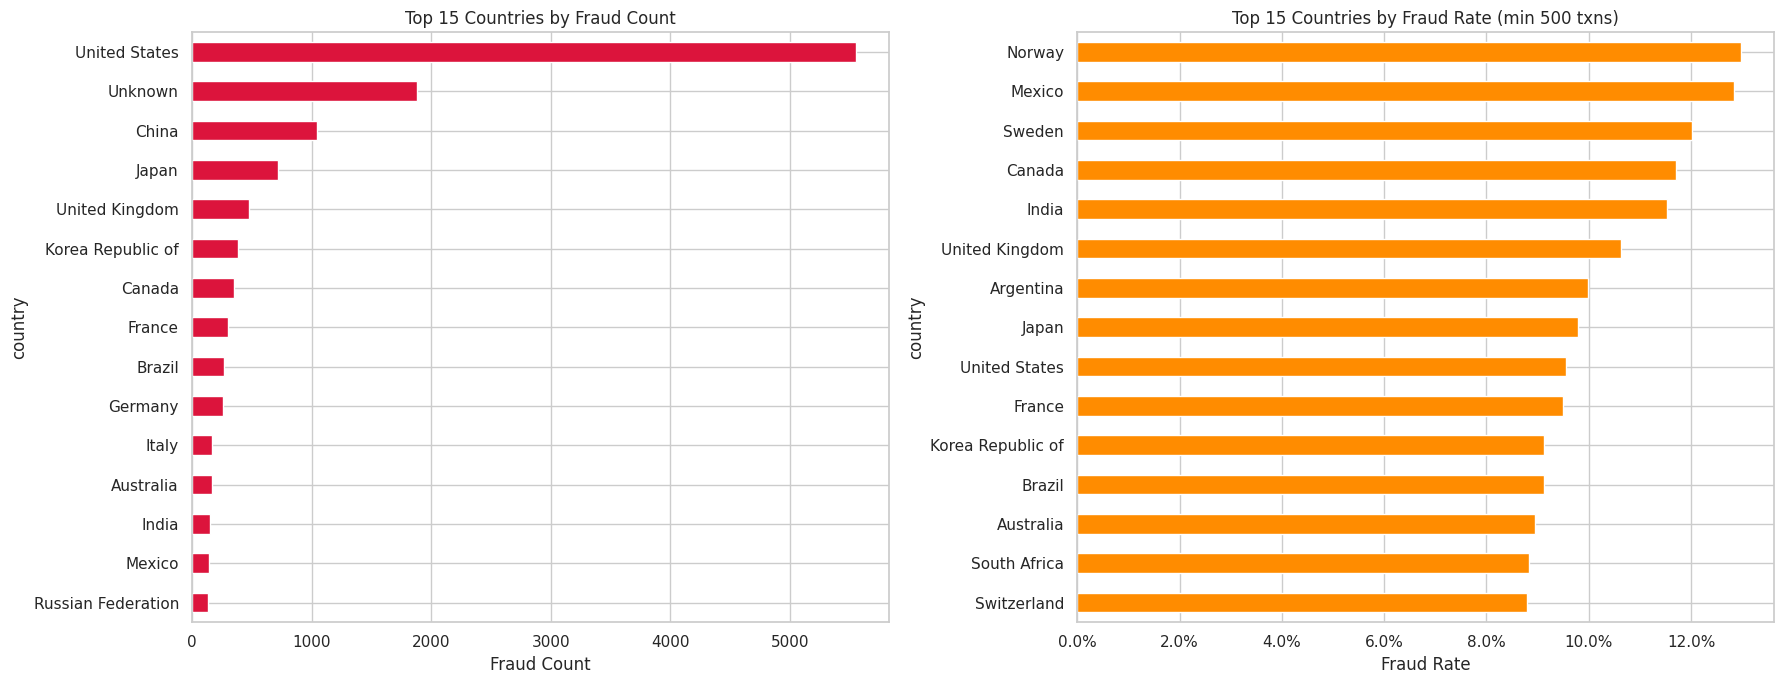

          country  total_transactions  fraud_count  fraud_rate
    United States               58049         5551    0.095626
          Unknown               21966         1883    0.085723
            China               12038         1043    0.086642
            Japan                7306          715    0.097865
   United Kingdom                4490          477    0.106236
Korea Republic of                4162          380    0.091302
           Canada                2975          348    0.116975
           France                3161          300    0.094907
           Brazil                2961          270    0.091185
          Germany                3646          262    0.071860


In [8]:
fraud_geo = merge_with_geolocation(fraud_df, ip_df)
country_stats = get_country_fraud_stats(fraud_geo, target_col='class')

top_count = get_top_countries_by_fraud_count(country_stats, top_n=15)
top_rate  = get_top_countries_by_fraud_rate(country_stats, min_transactions=500, top_n=15)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

top_count.plot(kind='barh', x='country', y='fraud_count', ax=axes[0],
               color='crimson', legend=False)
axes[0].set_title('Top 15 Countries by Fraud Count')
axes[0].set_xlabel('Fraud Count')
axes[0].invert_yaxis()

top_rate.plot(kind='barh', x='country', y='fraud_rate', ax=axes[1],
              color='darkorange', legend=False)
axes[1].set_title('Top 15 Countries by Fraud Rate (min 500 txns)')
axes[1].set_xlabel('Fraud Rate')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../models/plots/country_fraud.png', dpi=150, bbox_inches='tight')
plt.show()
print(top_count[['country','total_transactions','fraud_count','fraud_rate']].head(10).to_string(index=False))

## Summary

- **9.37% fraud rate** — highly imbalanced dataset
- **182 countries** mapped from IP ranges
- Key categorical drivers: `source`, `browser`, `sex`
- Country and purchase velocity are important geolocation signals